# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Спрогнозируем, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание проекта.

В нашем распоряжении имеются сведения о клиентах банка, на основе анализа которых стоит цель спрогнозировать вероятность "оттока" того или иного клиента.

Вероятность "оттока" - целевой признак, является бинарным (клиент либо остается, либо уходит), соответственно, стоит задача бинарной классификации. В рамках курса были рассмотрены три подходящих модели: Логистическая регрессия, Решающее дерево и Случайный лес.

В рамках проекта были проведены следующие этапы:

1. Предобработка данных. Данные оцениваются на предмет наличия пропусков, дубликатов. Проведем проверку соответствия типов данных содержимому колонок. Проверим наличие выбросов и аномалий в данных.

2. При необходимости проведем перекодировку техникой One hot encoding (категориальные признаки перекодируются в целочисленные значения). Кроме того, масштабируем данные (в целях повышения обучаемости моделей диапазоны численных значений признаков должны приблизительно соответствовать друг другу). Проведем разделение выборки на обучающую, валидационную и тестовую. Обучим модели и рассчитаем метрики F1 и Acceracy.

3. На третьем этапе сбалансируем соотношение целевого признака путем уменьшения, а также путем увеличения выборки и оценим, насколько устранение дибаланса улучшает метрики модели.

4. Протестируем результаты модели, а также сфорулируем итоговые выводы.

In [1]:
import pandas as pd

import random

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, f1_score, roc_curve

import matplotlib.pyplot as plt

## Подготовка данных

Считаем данные.

In [2]:
data = pd.read_csv('Churn.csv')

Выведем сведения о датафрейме.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Построим гистограммы для колонок датафрейма и описание методом describe().

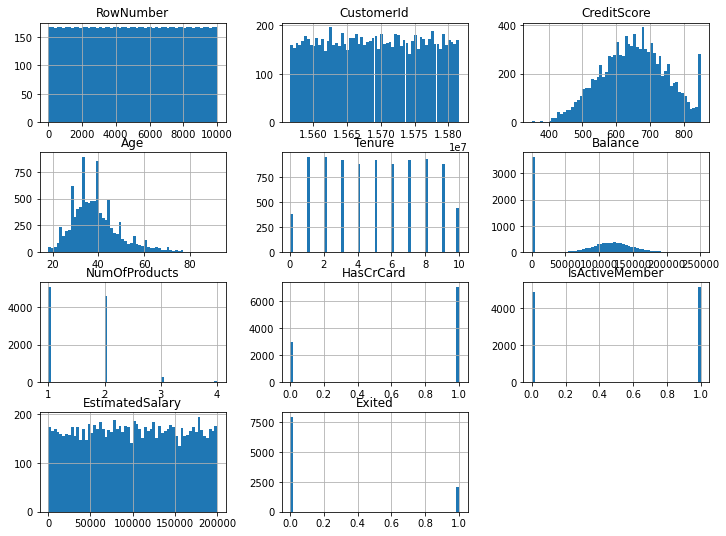

In [5]:
data.hist(figsize = (12, 9), bins = 60)
plt.show()

In [6]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Оценим количество пропусков в столбцах.

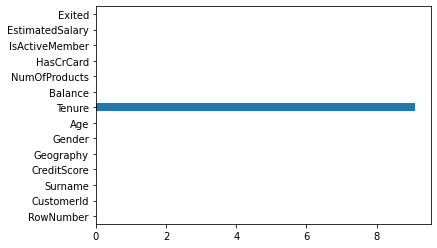

In [7]:
(data.isna().mean()*100).plot(kind = 'barh')
plt.show()

Промежуточные выводы:

Имеются пропуски в столбце Tenure, обработаем ниже.

Выбросы, аномалии не находим.

Типы данных преобразуем, где необходимо, в рамках метода OHE ниже.

## Исследование задачи

Колонки RowNumber, CustomerId и Surname, по всей видимости, прогностической ценностью не обладают, очистим от них датафрейм.

Колонки Geography и Gender следует преобразовать техникой OHE (с учетом необходимости избежать dummy ловушки).

Пропуски в колонке Tenure обработаем путем удаления строк с пропусками - объем данных достаточно большой.

Кроме того, необходимо провести стандартизацию данных.

In [8]:
data_ohe = data[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
             'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [9]:
data_ohe = data_ohe.fillna(0)

In [10]:
data_ohe.reset_index(drop = True, inplace = True)

Оценим, не приводит ли удаление пропусков к смещению распределений значений в колонках.

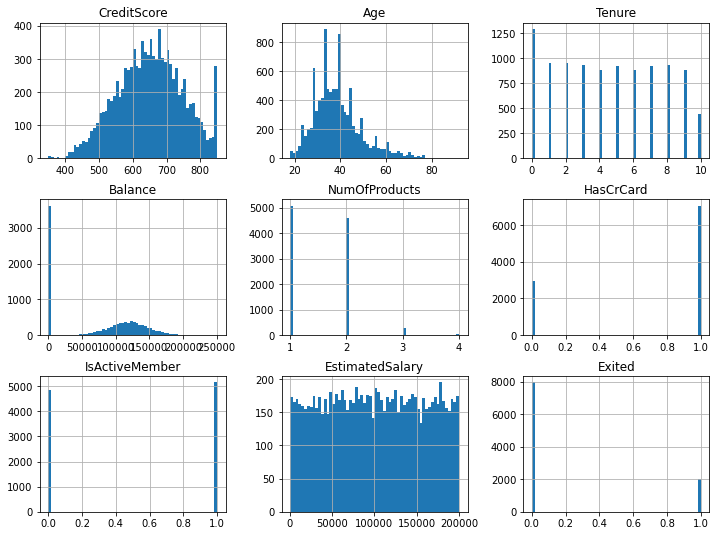

In [11]:
data_ohe.hist(bins = 60, figsize = (12, 9))
plt.show()

In [12]:
data_ohe.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Заметного смещения не произошло, продолжим.

In [13]:
data_ohe = pd.get_dummies(data_ohe, drop_first=True)

In [14]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Данные первично подготовлены к дальнейшему анализу, разделим датафрейм на обучающую и валидационную выборки.

In [15]:
features = data_ohe.drop('Exited', axis = 1)
target = data_ohe['Exited']

In [16]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.25, random_state = 12345)

Ниже проведем стандартизацию количественных признаков.

In [17]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None

In [18]:
features_train[numeric] = scaler.transform(features_train[numeric])

In [19]:
features_valid[numeric] = scaler.transform(features_valid[numeric])

Проверим результат.

In [20]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
226,0.442805,-0.841274,1.426885,-1.224577,0.817772,1,1,-1.269750,0,0,0
7756,-0.310897,-0.270730,0.784858,0.641783,-0.896874,1,1,0.960396,0,1,0
2065,-0.259274,-0.556002,1.105871,-1.224577,0.817772,1,0,0.661864,0,0,1
2800,1.217157,1.155631,1.426885,1.290462,0.817772,1,0,-1.039476,0,0,1
7028,0.690598,-1.221637,-1.462240,1.142121,-0.896874,0,0,-0.851729,1,0,1


In [21]:
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7867,-0.114728,0.680178,-0.499198,-1.224577,-0.896874,1,1,0.969342,0,1,0
1402,1.093261,-0.936365,1.105871,0.865861,-0.896874,1,0,-0.395081,0,0,1
8606,1.609496,0.299815,0.142830,-1.224577,0.817772,1,1,-0.439560,0,1,1
8885,0.174363,0.585087,-0.178184,0.419555,0.817772,1,1,1.006040,0,1,1
6494,0.494429,-1.031456,0.784858,-1.224577,0.817772,1,1,-1.343789,0,0,1


Стандартизация проведена корректно.

Обучим модель логистической регресии и проверим значение метрик F1 и AUC-ROC.

In [22]:
model = LogisticRegression(solver='liblinear', random_state = 12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Метрики логистической регресии:')
print('F1 score:', f1_score(target_valid, predicted_valid), 'AUC-ROC:', auc_roc)

Метрики логистической регресии:
F1 score: 0.29247910863509746 AUC-ROC: 0.7585465268364605


Повторим для модели решающего дерева.

In [23]:
model = DecisionTreeClassifier(max_depth = 5, random_state = 12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Метрики решающего дерева:')
print("Max depth = 5", 'F1 score:', f1_score(target_valid, predicted_valid), 'AUC-ROC:', auc_roc)

Метрики решающего дерева:
Max depth = 5 F1 score: 0.5704545454545454 AUC-ROC: 0.8424341870585718


И для случайного леса

In [24]:
model = RandomForestClassifier(n_estimators = 81, max_depth = 35, random_state = 12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Метрики случайного леса:')
print('N estimators = 81, max depth = 35')
print('F1 score:', f1_score(target_valid, predicted_valid), 'AUC-ROC:', auc_roc)

Метрики случайного леса:
N estimators = 81, max depth = 35
F1 score: 0.5820721769499417 AUC-ROC: 0.8539444959691803


Запомним полученные результаты и сравним, насколько далее взвешивание классов и оптимизация гиперпараметров моделей улучшит результаты. 

## Борьба с дисбалансом

Вернемся к исходному датафрейму и повторим начальные шаги подготовки данных (удалим лишние столбцы, строки с пропусками и проведем OHE).

In [25]:
data = data[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
             'IsActiveMember', 'EstimatedSalary', 'Exited']]
data = data.dropna(subset = ['Tenure'])
data.reset_index(drop = True, inplace = True)
data = pd.get_dummies(data, drop_first=True)

Проверим дисбаланс классов.

In [26]:
data.Exited.mean()

0.2039379606203938

Проведем разделение выборки на тестовую, валидационную и обучающую в пропорции 20:20:60 соответственно.

In [27]:
features = data.drop('Exited', axis = 1)
target = data['Exited']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.20, random_state = 12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size = 0.25, random_state = 12345)

Ниже стандартизация признаков.

In [28]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Теперь можем перейти к работе с дисбалансом классов. Начнем с увеличения выборки.

In [29]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(8811, 11)
(8811,)


In [30]:
target_upsampled.mean()

0.5080013619339462

Рассчитаем метрики для трех моделей. (Перебор гиперпараметров циклом тут не приводим, приведем сразу оптимальные параметры).

In [31]:
modelLR = LogisticRegression(solver='liblinear', random_state = 12345, class_weight = 'balanced')
modelLR.fit(features_upsampled, target_upsampled)
predicted_valid = modelLR.predict(features_valid)
probabilities_valid = modelLR.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 score (balanced):', f1_score(target_valid, predicted_valid), 'AUC-ROC (balanced):', auc_roc)

F1 score (balanced): 0.49506903353057197 AUC-ROC (balanced): 0.7747237652230201


По сравнению с логистической регрессией несбалансированной выборки метрики выросли.

In [32]:
modelDT = DecisionTreeClassifier(max_depth = 7, random_state = 12345, class_weight = 'balanced')
modelDT.fit(features_upsampled, target_upsampled)
predicted_valid = modelDT.predict(features_valid)
probabilities_valid = modelDT.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Max depth = 7', 'F1 score (balanced):', f1_score(target_valid, predicted_valid), 'AUC-ROC (balanced):', auc_roc)

Max depth = 7 F1 score (balanced): 0.5458207452165156 AUC-ROC (balanced): 0.8091769031597645


In [33]:
modelRF = RandomForestClassifier(n_estimators = 251, max_depth = 13, random_state = 12345, class_weight = 'balanced')
modelRF.fit(features_upsampled, target_upsampled)
predicted_valid = modelRF.predict(features_valid)
probabilities_valid = modelRF.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('N est = 251', 'max depth = 13', 'F1 score (balanced):', f1_score(target_valid, predicted_valid), 'AUC-ROC (balanced):', auc_roc)

N est = 251 max depth = 13 F1 score (balanced): 0.5912305516265912 AUC-ROC (balanced): 0.8440157912959703


Максимальный F1 и AUC - ROC достигнут моделью RandomForestClassifier при количестве деревьев 251 и глубине 13

Уменьшение выборки.

In [34]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2203, 11)
(2203,)


In [35]:
target_downsampled.mean()

0.5079437131184749

In [36]:
modelLR1 = LogisticRegression(solver='liblinear', random_state = 12345, class_weight = 'balanced')
modelLR1.fit(features_downsampled, target_downsampled)
predicted_valid = modelLR1.predict(features_valid)
probabilities_valid = modelLR1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 score (balanced):', f1_score(target_valid, predicted_valid), 'AUC-ROC (balanced):', auc_roc)

F1 score (balanced): 0.49849246231155775 AUC-ROC (balanced): 0.7754933839136522


In [37]:
modelDT1 = DecisionTreeClassifier(max_depth = 5, random_state = 12345, class_weight = 'balanced')
modelDT1.fit(features_downsampled, target_downsampled)
predicted_valid = modelDT1.predict(features_valid)
probabilities_valid = modelDT1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 score (balanced):', f1_score(target_valid, predicted_valid), 'AUC-ROC (balanced):', auc_roc)

F1 score (balanced): 0.553191489361702 AUC-ROC (balanced): 0.8094826807568983


In [38]:
modelRF1 = RandomForestClassifier(n_estimators = 251, max_depth = 13, random_state = 12345, class_weight = 'balanced')
modelRF1.fit(features_downsampled, target_downsampled)
predicted_valid = modelRF1.predict(features_valid)
probabilities_valid = modelRF1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 score (balanced):', f1_score(target_valid, predicted_valid), 'AUC-ROC (balanced):', auc_roc)

F1 score (balanced): 0.5838779956427015 AUC-ROC (balanced): 0.845331105390718


При уменьшении выборки наилучший результат достигается также моделью RandomForestClassifier, однако результаты увеличения выборки более высокие. Проведем тестирование наилучшей модели (она сохранена).

## Тестирование модели

In [39]:
probabilities_test = modelRF.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
predicted_test = modelRF.predict(features_test)
print('F1 score:', f1_score(target_test, predicted_test), 'AUC-ROC:', auc_roc)

F1 score: 0.6019151846785226 AUC-ROC: 0.85272030651341


Итоговый результат не значительно уступает полученному на валидационной выборке. Можем применить модель для прогнозирования оттока клиентов.

Добавим визуализацию ROC-кривой.

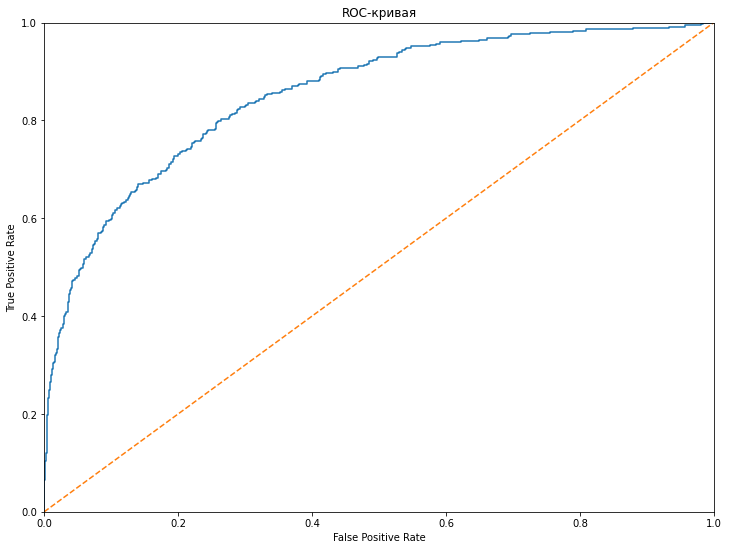

In [40]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize = (12, 9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Численный показатель AUC - ROC показывает площадь под ROC - кривой, площадь под случайной ROC - кривой (нанесена пунктиром) составляет 0.5. AUC - ROC обученной модели составляет 0.85, что заметно лучше случайной модели.

Визуально можем оценить, что форма ROC - кривой обученной модели также существенно лучше случайной (лежит выше левее).

Рост True Positive Rate, например с 0.2 до 0.4 не влечет за собой сопоставимого увеличения False Positive Rate, т. е. модель обладает прогностической способностью, основанной на выявленных закономеростях, а не случайной классификации. 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*